<a href="https://colab.research.google.com/github/dudeurv/SAMed/blob/main/BraTS_SAMed_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download codes, pretrained weights and test data

# Setup environment

In [ ]:
!pip install einops==0.6.1
!pip install icecream==2.1.3
!pip install MedPy==0.4.0
!pip install monai==1.1.0
!pip install opencv_python==4.5.4.58
!pip install SimpleITK==2.2.1
!pip install tensorboardX==2.6
!pip install ml-collections==0.1.1
!pip install onnx==1.13.1
!pip install onnxruntime==1.14.1
!pip install tensorboardX
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 26.5 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214949 sha256=78ff8f651c4d1322cabf68fa5e1b9a42385d5932920be609898c99d435413c72
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built MedPy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: opencv_python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.2 MB/s eta 0:00:00
  Atte

# Download codes, pretrained weights and test data

In [ ]:
import os

CODE_DIR = 'samed_codes'

# Create the parent directory
os.makedirs(f'./{CODE_DIR}', exist_ok=True)

# Clone the SAMed repository into its subfolder
!git clone https://github.com/dudeurv/SAMed.git $CODE_DIR

os.chdir(f'./{CODE_DIR}')

os.listdir()

Cloning into 'samed_codes'...
remote: Enumerating objects: 536, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 536 (delta 279), reused 273 (delta 190), pack-reused 123
Receiving objects: 100% (536/536), 803.78 KiB | 12.76 MiB/s, done.
Resolving deltas: 100% (298/298), done.


['subsample_datasets.py',
 'BraTS_SAMed_train.ipynb',
 'requirements.txt',
 '.gitignore',
 'eval_BraTS.py',
 'BraTS_SAMed_train_command_line.ipynb',
 'segment_anything',
 '.git',
 'trainer.py',
 'utils.py',
 'datasets',
 'lists',
 'materials',
 'dataset_BraTS.py',
 'train.py',
 'preprocess',
 'README.md',
 'test.py',
 'sam_lora_image_encoder_mask_decoder.py',
 'sam_lora_image_encoder.py',
 'train_BraTS.py',
 'trainer_BraTS.py']

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

download_with_pydrive = True

class Downloader(object):
  def __init__(self, use_pydrive):
    self.use_pydrive = use_pydrive
    current_directory = os.getcwd()
    self.save_dir = '.'
    if self.use_pydrive:
      self.authenticate()

  def authenticate(self):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)

  def download_file(self, file_id, file_name):
    file_dst = f'{self.save_dir}/{file_name}'
    if os.path.exists(file_dst):
      print(f'{file_name} already exists')
      return
    downloaded = self.drive.CreateFile({'id': file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(file_dst)

downloader = Downloader(download_with_pydrive)

sam_model = {'id': '1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg', 'name': 'sam_vit_b_01ec64.pth'}
downloader.download_file(file_id=sam_model['id'], file_name=sam_model['name'])
data = {'id': '1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv', 'name': 'Slices.zip'}
downloader.download_file(file_id=data['id'], file_name=data['name'])

In [ ]:
!unzip -n Slices.zip -d /content/samed_codes/ > /dev/null 2>&1

# Execute SAMed

### ***From trainer.py***

In [ ]:
!pip install torchmetrics

In [ ]:
import argparse
import logging
import os
import random
import sys
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from utils import DiceLoss, Focal_loss
from torchvision import transforms
from icecream import ic

from eval_BraTS import test_per_epoch, calc_loss

def trainer_BraTS(args, model, snapshot_path, multimask_output, low_res):
    from dataset_BraTS import BraTS_dataset
    base_lr = args.base_lr
    num_classes = args.num_classes
    batch_size = args.batch_size * args.n_gpu
    # max_iterations = args.max_iterations
    db_train = BraTS_dataset(base_dir=args.root_path)
    db_test = BraTS_dataset(base_dir='/content/samed_codes/Slices/Test')
    print("The length of train set is: {}".format(len(db_train)))

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    trainloader = DataLoader(db_train, batch_size=5, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    testloader = DataLoader(db_test, batch_size=10, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    if args.n_gpu > 1:
        model = nn.DataParallel(model)
    model.train()

    if args.warmup:
        b_lr = base_lr / args.warmup_period
    else:
        b_lr = base_lr
    if args.AdamW:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, momentum=0.9, weight_decay=0.0001)  # Even pass the model.parameters(), the `requires_grad=False` layers will not update
    writer = SummaryWriter(snapshot_path + '/log')
    iter_num = 0
    max_epoch = args.max_epochs
    stop_epoch = args.stop_epoch
    best_epoch, best_loss = 0.0, np.inf
    max_iterations = args.max_epochs * len(trainloader)  # max_epoch = max_iterations // len(trainloader) + 1
    print("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))
    best_performance = 0.0
    iterator = tqdm(range(max_epoch), ncols=70)
    for epoch_num in iterator:
        for i_batch, (image_batch, label_batch) in enumerate(trainloader):
            # Original shape of image and label batch

            image_batch, label_batch = image_batch.unsqueeze(1).float().cuda(), label_batch.unsqueeze(1).cuda()
            image_batch = image_batch.repeat(1, 3, 1, 1)
            # Resize the target
            label_batch = F.interpolate(label_batch, size=(128, 128), mode='nearest')
            label_batch = label_batch.squeeze(1)

            label_batch = torch.clamp(label_batch, 0, num_classes-1)

            assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
            outputs = model(image_batch, multimask_output, args.img_size)
            # Check the shape and content of the model output

            loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, args.dice_param, num_classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if args.warmup and iter_num < args.warmup_period:
                lr_ = base_lr * ((iter_num + 1) / args.warmup_period)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                if args.warmup:
                    shift_iter = iter_num - args.warmup_period
                    assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                else:
                    shift_iter = iter_num
                lr_ = base_lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_

        # Testing at the end of each epoch
        test_loss, test_loss_ce, test_loss_dice = test_per_epoch(model, testloader, multimask_output, args.img_size)

        # Update best model if current epoch's loss is lower
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch_num
            torch.save(model.state_dict(), os.path.join(snapshot_path, 'model_best_epoch_{:03d}.pth'.format(best_epoch)))
            print("New best model saved with loss {:.4f}".format(best_loss))

        # Switch to evaluation mode
        model.eval()
        import matplotlib as plt
        # Run visualization and evaluation
        dices_per_class = vis_per_epoch1(model, testloader, multimask_output, img_size=128)  # img_size should match the expected input size of your model

        # Output the results
        print("Dices per class:", dices_per_class)
        print("Overall Dice:", np.mean(list(dices_per_class.values())))

        # Log at the end of each epoch
        print(f'--- Epoch {epoch_num}/{args.max_epochs}: Training loss = {loss:.4f}, Testing loss = {test_loss:.4f}, Best loss = {best_loss:.4f}, Best epoch = {best_epoch}')

        if (epoch_num + 1) % 2 == 0 or epoch_num >= args.max_epochs or epoch_num >= args.stop_epoch :
            save_mode_path = os.path.join(snapshot_path, 'epoch_{:03d}.pth'.format(epoch_num))
            torch.save(model.state_dict(), save_mode_path)
            print("Model saved to {}".format(save_mode_path))

            if epoch_num >= args.max_epochs - 1 or epoch_num >= args.stop_epoch - 1:
                iterator.close()
                break


    writer.close()
    return "Training Finished!"

In [ ]:
# Define a function to calculate the confusion matrix from predictions and ground truths
def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    # Stack the ground truth and prediction arrays and transpose
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    # Compute the confusion matrix using histogram
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),  # Number of bins for each dimension (nr_labels)
        range=[(0, nr_labels), (0, nr_labels)]  # Range of labels
    )
    # Convert the confusion matrix to uint32 for consistency
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

# Define a function to calculate the Dice coefficient from the confusion matrix
def calculate_dice(confusion_matrix):
    dices = []  # Initialize a list to store Dice scores for each class
    # Iterate over each class to calculate Dice score
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]  # Diagonal elements are true positives
        # Sum of the column for the class minus true positives gives false positives
        false_positives = confusion_matrix[:, index].sum() - true_positives
        # Sum of the row for the class minus true positives gives false negatives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        # The denominator in the Dice score formula
        denom = 2 * true_positives + false_positives + false_negatives
        # Handle the case where denominator is zero (to avoid division by zero)
        if denom == 0:
            dice = 0
        else:
            # Dice score calculation: 2 times the number of true positives divided by the denominator
            dice = 2 * float(true_positives) / denom
        dices.append(dice)  # Append the Dice score for the current class to the list
    return dices


# Define a function to test the model for an epoch and visualize the results
def vis_per_epoch1(model, testloader, multimask_output, img_size):
    import matplotlib.pyplot as plt
    model.eval()
    num_classes = 8
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)

    with torch.no_grad():

        for batch_idx, (image_batch, label_batch) in enumerate(testloader):

            image_batch, label_batch = image_batch.unsqueeze(1).float().cuda(), label_batch.unsqueeze(1).cuda()
            image_batch = image_batch.repeat(1, 3, 1, 1)

            label_batch = F.interpolate(label_batch, size=(128, 128), mode='nearest')
            label_batch = label_batch.squeeze(1)

            label_batch = torch.clamp(label_batch, 0, num_classes-1)

            output = model(image_batch, multimask_output, img_size)
            logits = output['low_res_logits']

            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)

            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)

            img_num = 0
            axs[batch_idx, 0].imshow(image_batch[img_num, 0].cpu().numpy(), cmap='gray')
            axs[batch_idx, 1].imshow(label_batch[img_num].cpu().numpy(), cmap='gray')
            axs[batch_idx, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')

    confusion_matrix = confusion_matrix[1:, 1:]

    dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    plt.axis('OFF')
    plt.tight_layout()
    plt.show()
    return dices_per_class

import torch
from importlib import import_module

### ***From train.py***

torch.Size([3, 1, 1])
The length of train set is: 1395
279 iterations per epoch. 2790 max iterations 


  0%|                                          | 0/10 [00:00<?, ?it/s]

New best model saved with loss 0.6990


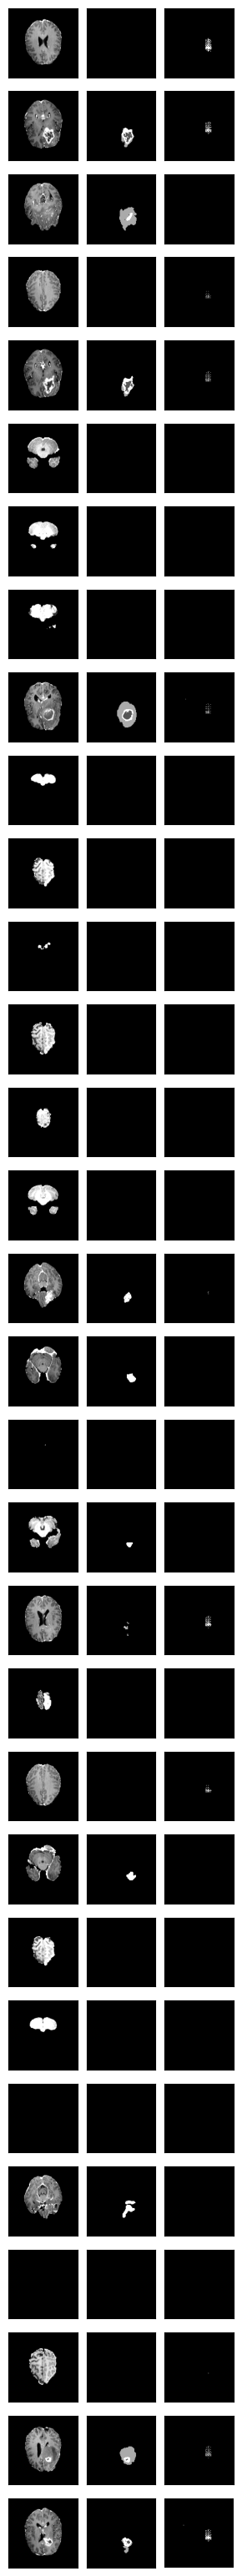

 10%|███▎                             | 1/10 [05:48<52:16, 348.52s/it]

Dices per class: {'dice_cls:1': 0.0, 'dice_cls:2': 0.6923411662315057, 'dice_cls:3': 0.045416316232127836, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.10539392606623335
--- Epoch 0/10: Training loss = 0.7132, Testing loss = 0.6990, Best loss = 0.6990, Best epoch = 0
New best model saved with loss 0.2896


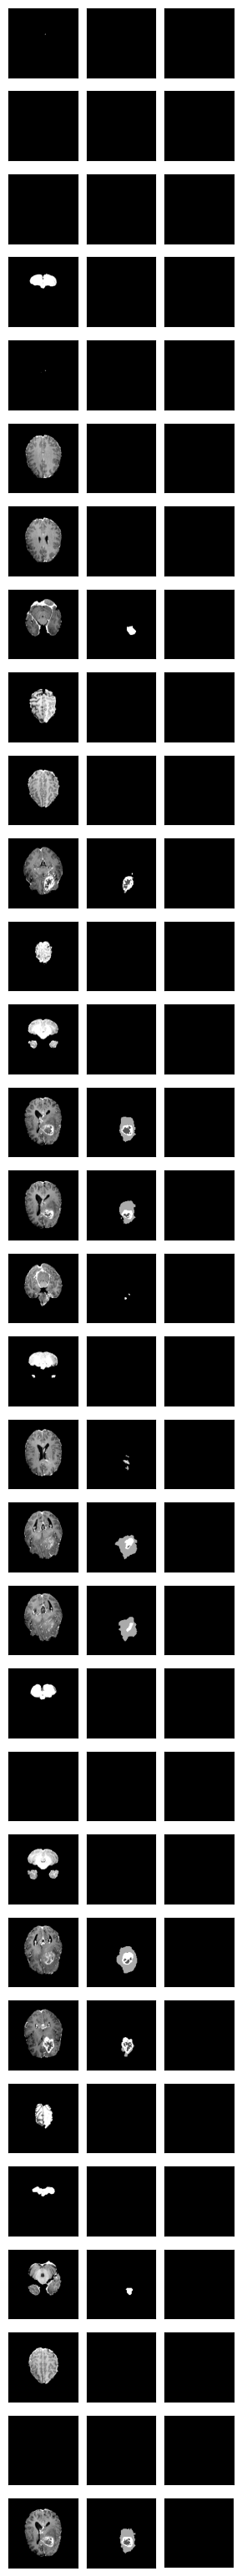

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 1/10: Training loss = 0.3025, Testing loss = 0.2896, Best loss = 0.2896, Best epoch = 1


 20%|██████▌                          | 2/10 [11:37<46:28, 348.54s/it]

Model saved to /content/samed_codes/training_output/BraTS_512_pretrain_vit_b_10k_epo10_bs10_lr0.005/epoch_001.pth
New best model saved with loss 0.2864


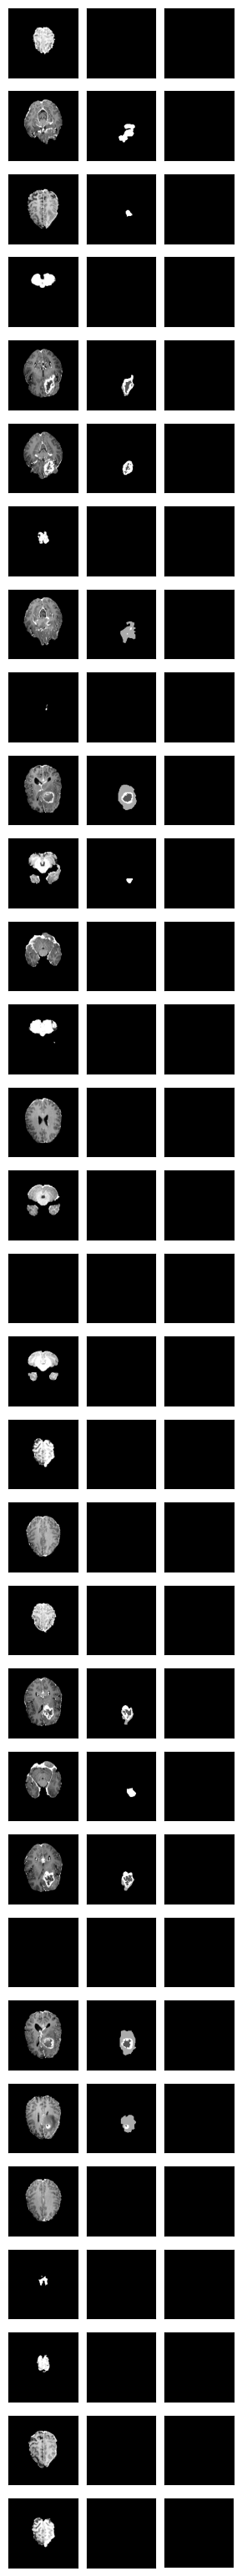

 30%|█████████▉                       | 3/10 [17:25<40:37, 348.27s/it]

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 2/10: Training loss = 0.2719, Testing loss = 0.2864, Best loss = 0.2864, Best epoch = 2


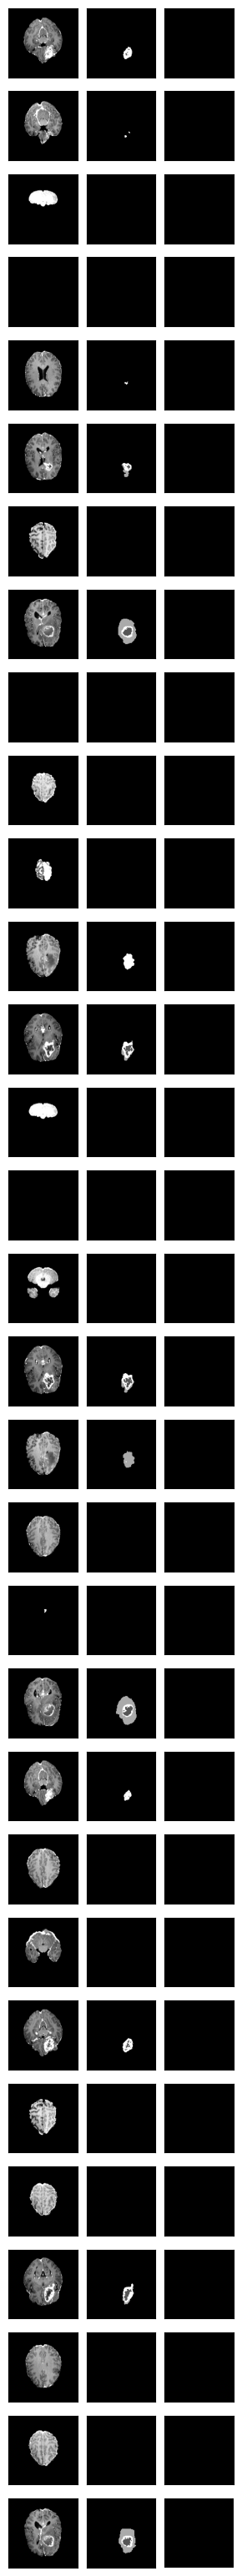

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 3/10: Training loss = 0.2791, Testing loss = 0.2943, Best loss = 0.2864, Best epoch = 2


 40%|█████████████▏                   | 4/10 [23:12<34:48, 348.02s/it]

Model saved to /content/samed_codes/training_output/BraTS_512_pretrain_vit_b_10k_epo10_bs10_lr0.005/epoch_003.pth


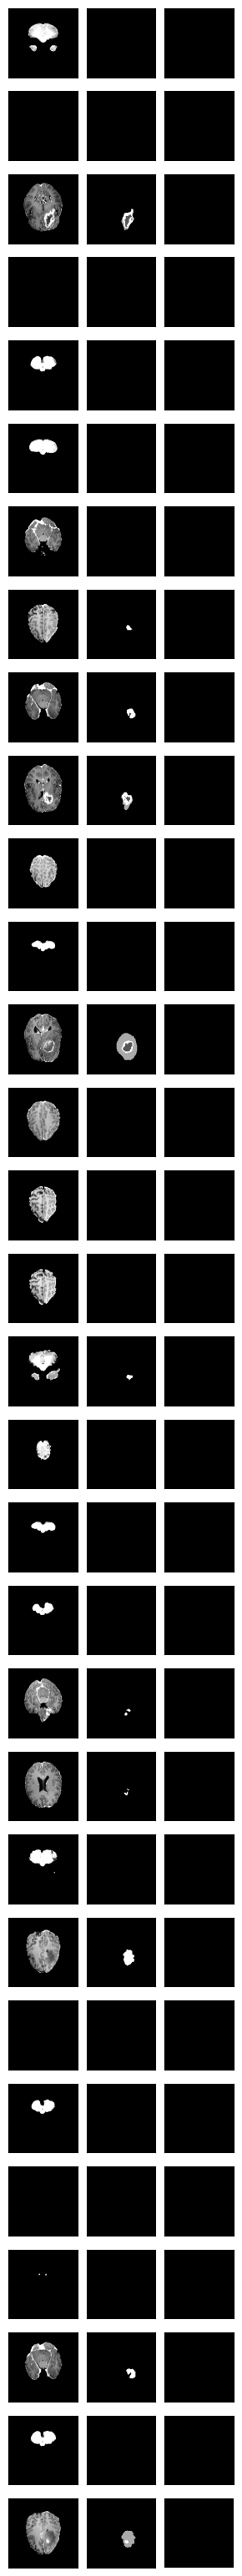

 50%|████████████████▌                | 5/10 [29:00<28:58, 347.79s/it]

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 4/10: Training loss = 0.3078, Testing loss = 0.2933, Best loss = 0.2864, Best epoch = 2


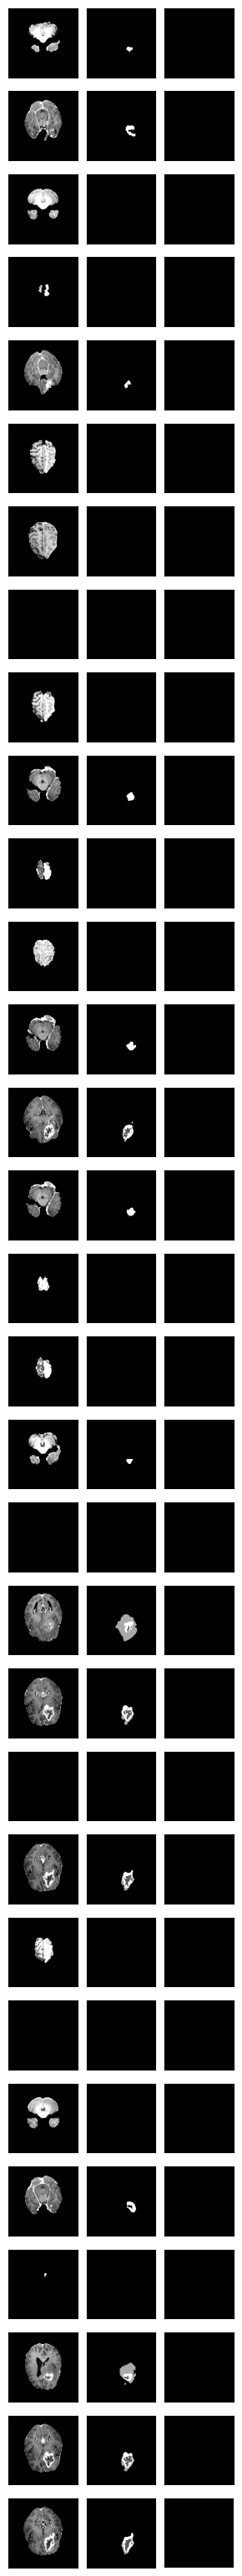

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 5/10: Training loss = 0.3124, Testing loss = 0.2867, Best loss = 0.2864, Best epoch = 2


 60%|███████████████████▊             | 6/10 [34:48<23:11, 347.87s/it]

Model saved to /content/samed_codes/training_output/BraTS_512_pretrain_vit_b_10k_epo10_bs10_lr0.005/epoch_005.pth


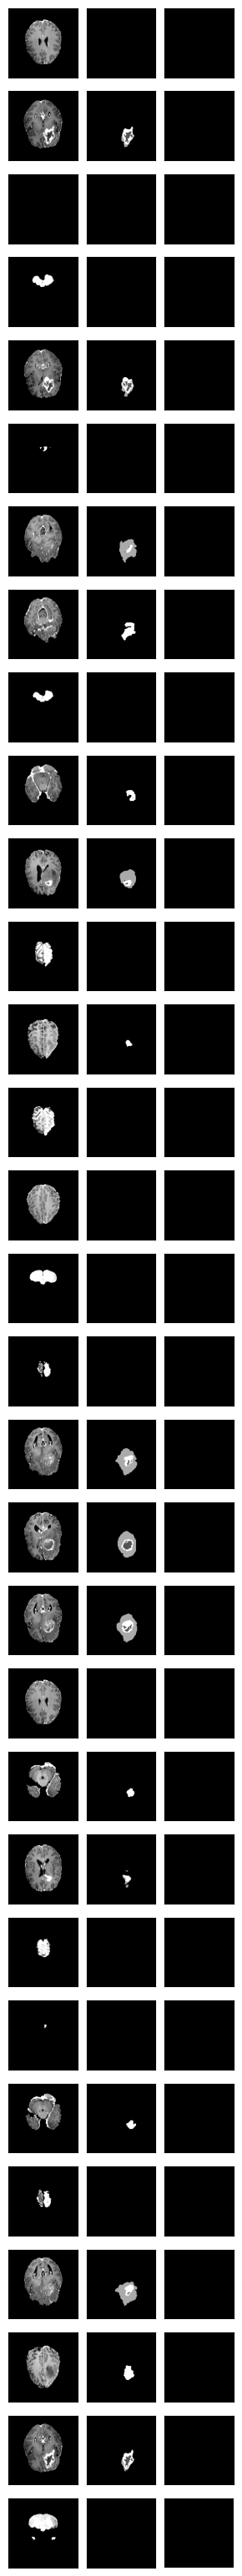

 70%|███████████████████████          | 7/10 [40:35<17:22, 347.64s/it]

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 6/10: Training loss = 0.2989, Testing loss = 0.2943, Best loss = 0.2864, Best epoch = 2


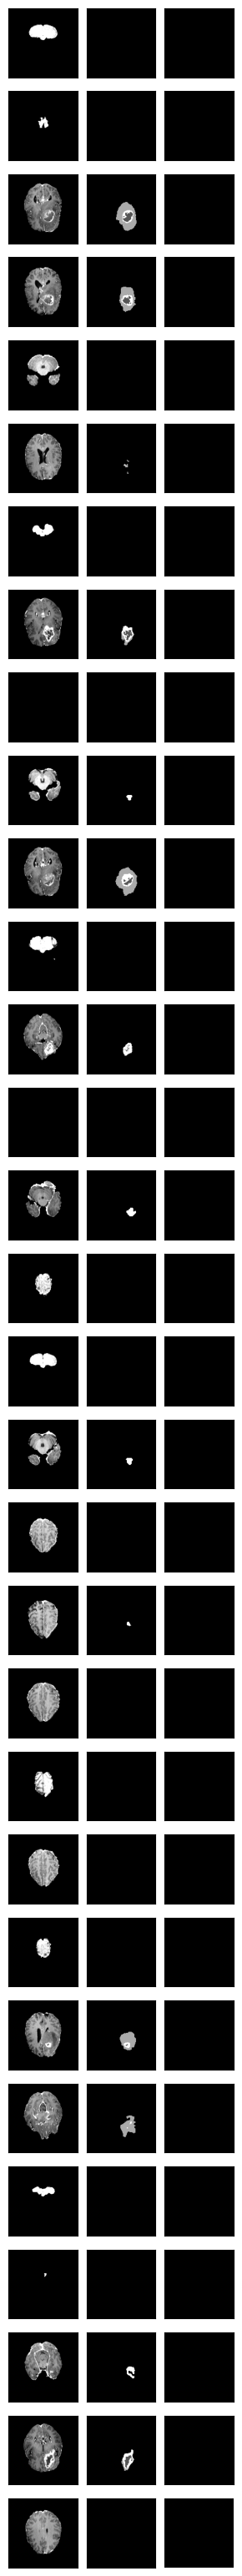

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 7/10: Training loss = 0.2164, Testing loss = 0.2892, Best loss = 0.2864, Best epoch = 2


 80%|██████████████████████████▍      | 8/10 [46:22<11:35, 347.54s/it]

Model saved to /content/samed_codes/training_output/BraTS_512_pretrain_vit_b_10k_epo10_bs10_lr0.005/epoch_007.pth


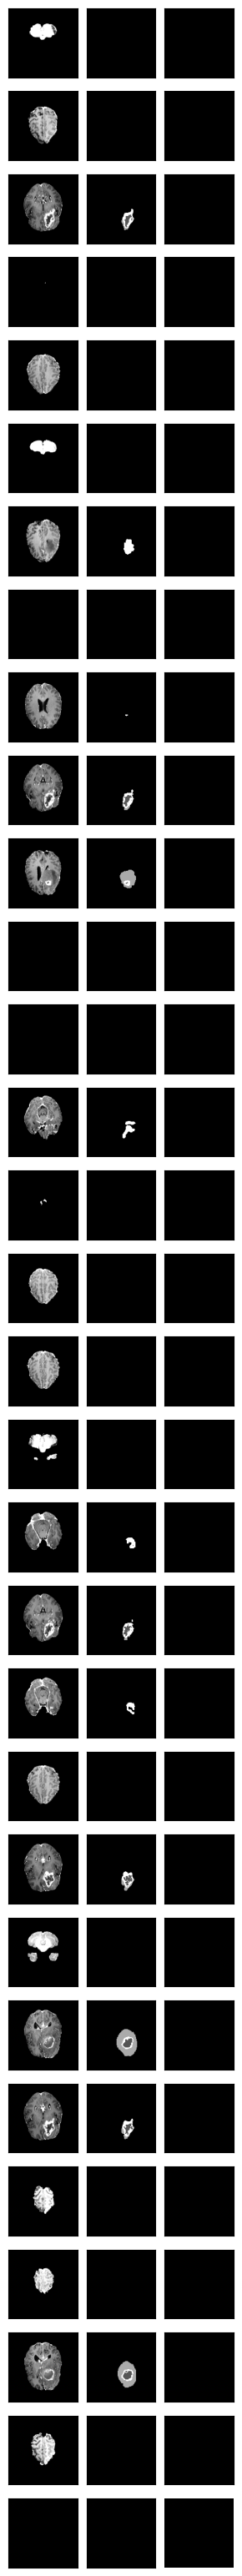

 90%|█████████████████████████████▋   | 9/10 [52:09<05:47, 347.25s/it]

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 8/10: Training loss = 0.1873, Testing loss = 0.2914, Best loss = 0.2864, Best epoch = 2


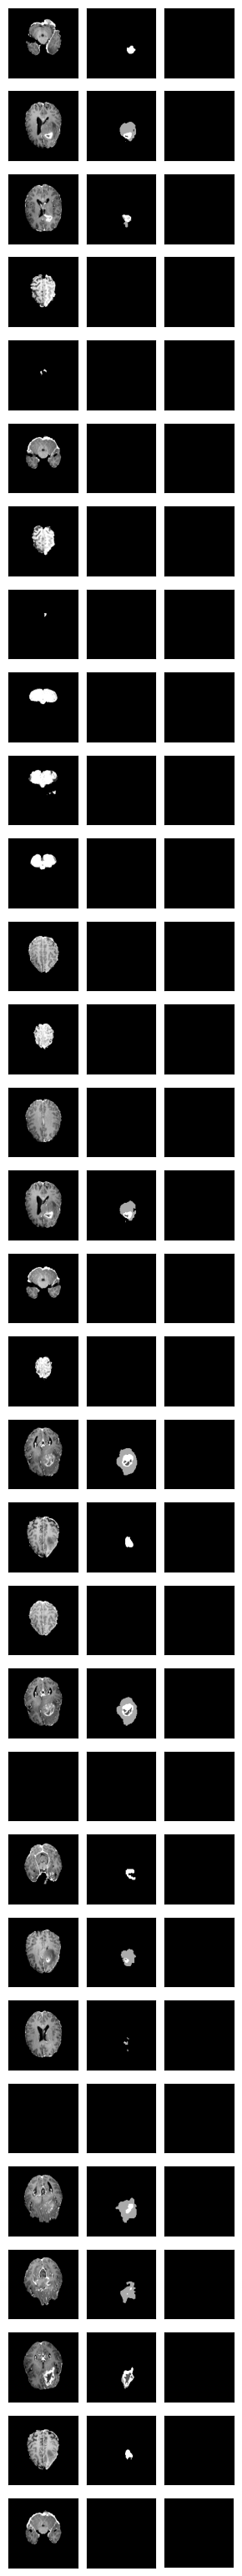

Dices per class: {'dice_cls:1': 0, 'dice_cls:2': 0, 'dice_cls:3': 0, 'dice_cls:4': 0, 'dice_cls:5': 0, 'dice_cls:6': 0, 'dice_cls:7': 0}
Overall Dice: 0.0
--- Epoch 9/10: Training loss = 0.3224, Testing loss = 0.2974, Best loss = 0.2864, Best epoch = 2


 90%|█████████████████████████████▋   | 9/10 [57:57<06:26, 386.38s/it]

Model saved to /content/samed_codes/training_output/BraTS_512_pretrain_vit_b_10k_epo10_bs10_lr0.005/epoch_009.pth


'Training Finished!'

In [ ]:
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn

from importlib import import_module

from sam_lora_image_encoder import LoRA_Sam
from segment_anything import sam_model_registry

from icecream import ic

# Manually set the arguments
args = argparse.Namespace(
    root_path='/content/samed_codes/Slices/Train',
    output='/content/samed_codes/training_output',
    dataset='BraTS',
    num_classes=8,
    max_iterations=100,
    max_epochs=10,
    stop_epoch=11,
    batch_size=10,
    n_gpu=2,
    deterministic=1,
    base_lr=0.005,
    img_size=512,
    seed=1234,
    vit_name='vit_b',
    ckpt='/content/samed_codes/sam_vit_b_01ec64.pth',
    lora_ckpt=None,
    rank=4,
    warmup=True,  # True if you want to use warmup
    warmup_period=250,
    AdamW=True,  # True if you want to use AdamW
    module='sam_lora_image_encoder',
    dice_param=0.8
)


if not args.deterministic:
    cudnn.benchmark = True
    cudnn.deterministic = False
else:
    cudnn.benchmark = False
    cudnn.deterministic = True

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
dataset_name = args.dataset
dataset_config = {
    'BraTS': {
        'root_path': args.root_path,
        'num_classes': args.num_classes,
    }
}
args.is_pretrain = True
args.exp = dataset_name + '_' + str(args.img_size)
snapshot_path = os.path.join(args.output, "{}".format(args.exp))
snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
snapshot_path += '_' + args.vit_name
snapshot_path = snapshot_path + '_' + str(args.max_iterations)[
                                      0:2] + 'k' if args.max_iterations != 30000 else snapshot_path
snapshot_path = snapshot_path + '_epo' + str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
snapshot_path = snapshot_path + '_bs' + str(args.batch_size)
snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
snapshot_path = snapshot_path + '_s' + str(args.seed) if args.seed != 1234 else snapshot_path

if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)

# register model
sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                            num_classes=args.num_classes,
                                                            checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                            pixel_std=[1, 1, 1])

pkg = import_module(args.module)
net = pkg.LoRA_Sam(sam, args.rank).cuda()

# net = LoRA_Sam(sam, args.rank).cuda()
if args.lora_ckpt is not None:
    net.load_lora_parameters(args.lora_ckpt)

if args.num_classes > 1:
    multimask_output = True
else:
    multimask_output = False

low_res = img_embedding_size * 4

config_file = os.path.join(snapshot_path, 'config.txt')
config_items = []
for key, value in args.__dict__.items():
    config_items.append(f'{key}: {value}\n')

with open(config_file, 'w') as f:
    f.writelines(config_items)

trainer = {'BraTS': trainer_BraTS}
trainer[dataset_name](args, net, snapshot_path, multimask_output, low_res)